Introduction:
In the the table there are 4 columns f: observed frequency , x and y: coordinated on celestial sphere , p: power
the measuring units of the rest frequencies is MHz . 
HI (1420.4057) , OH (1612.2310 , 1665.4018, 1667.3590) , H20 (22235.0799) , NH3 (23694.5060 , 23722.6340, 23870.1300)

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from lmfit import Model
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter


data=pd.read_excel('/Users/User/Downloads/spectrum_data_excel.xlsx' , header=None)
data.columns=("f", "x", "y", "p")

rest_f=[1420.4057, 1612.2310, 1665.4018, 1667.3590, 22235.0799, 23694.5060, 23722.6340, 23870.1300]

Gaussian distribution

True peak: ( 1420.261328 , 1.721924 )


C:\Users\User\AppData\Roaming\Python\Python310\site-packages\lmfit\model.py:1053: UserWarning: The keyword argument A does not match any arguments of the model function. It will be ignored.
  warnings.warn(f"The keyword argument {name} does not " +


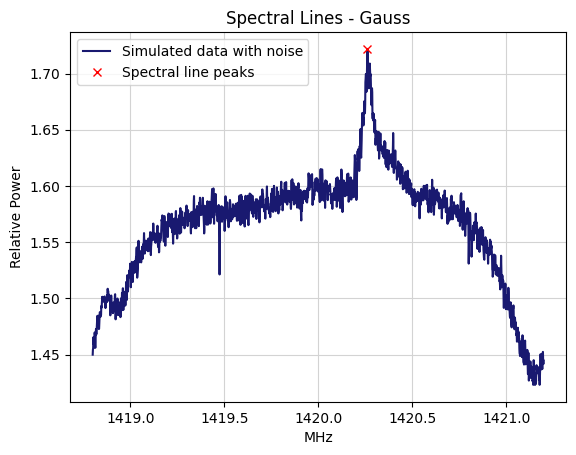

Peak: (1420.261328, 1.721924)
[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 95
    # data points      = 100
    # variables        = 2
    chi-square         = 0.02539473
    reduced chi-square = 2.5913e-04
    Akaike info crit   = -823.838365
    Bayesian info crit = -818.628025
    R-squared          = 0.70834922
[[Variables]]
    sigma:  0.23761914 +/- 2.6118e-04 (0.11%) (init = 1)
    mu:     1420.27079 +/- 0.00162854 (0.00%) (init = 1420.261)
[[Correlations]] (unreported correlations are < 0.100)
    C(sigma, mu) = -0.4335


In [13]:
maxp_true = np.max(data.p)
maxf_true = data.loc[data['p'].idxmax(), 'f']
print("True peak:", "(",maxf_true, ",", maxp_true,")")

std = np.std(data.f)
mn = np.mean(data.f)
def gaussian(x, sigma , mu):
    A = 1/ (sigma * np.sqrt(2*np.pi))
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

gvalues= gaussian(data.f, std , mn)
maxg = np.max(gvalues)
X_values = data.f
Y_values = data.p
smoothed_y = gaussian_filter(Y_values , std)
peaks, _ = find_peaks(Y_values , prominence = 0.1)
gmodel = Model(gaussian)
results = {}

for i in peaks:
    start_index = max(0, i - 50)
    end_index = min(len(X_values), i + 50)
    result = gmodel.fit(Y_values[start_index:end_index], x=X_values[start_index:end_index], A=1, mu=X_values[i], sigma=1, method='leastsq')
    results[i] = result

plt.plot(data.f , data.p , color= 'midnightblue', label= 'Simulated data with noise')



plt.plot(X_values[peaks], Y_values[peaks], 'rx', label='Spectral line peaks')

plt.xlabel('MHz')
plt.ylabel('Relative Power')
plt.title('Spectral Lines - Gauss')
plt.legend()
plt.show()

for i, result in results.items():
    print(f"Peak: ({X_values[i]}, {Y_values[i]})")
    print(result.fit_report())

Rolling mean and Gaussian function comparison

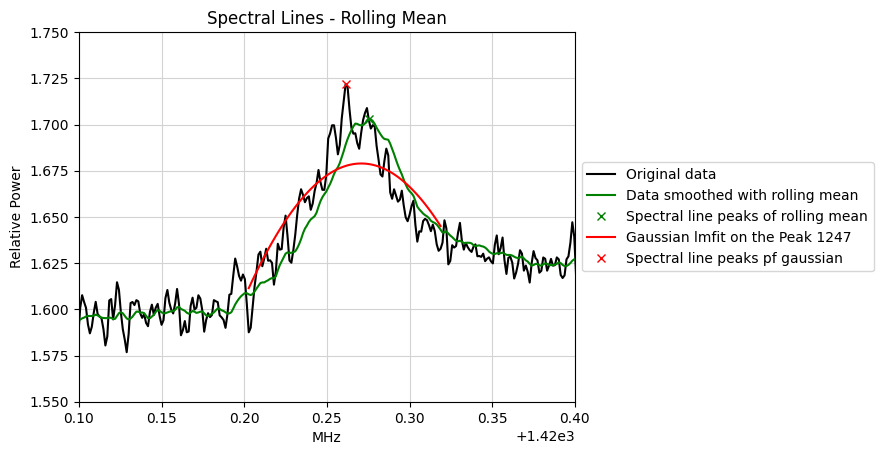

Values peak2: ( <FloatingArray>
[1420.2754]
Length: 1, dtype: Float32 , <FloatingArray>
[1420.2754]
Length: 1, dtype: Float32 )


In [47]:
data['rolp']=data['p'].rolling(15).mean()
max_p=data['rolp'].max()
max_fobs = data.loc[data['rolp'].idxmax(), 'f']

peaks2, _ = find_peaks(data.rolp , prominence = 0.1)
peak_valuef= pd.array(data.f[peaks2], dtype=pd.Float32Dtype())
peak_valuep= data.rolp[peaks2]

plt.plot( data.f , data.p , color = "black", label='Original data')
plt.plot(data.f , data.rolp , color= 'g', label= 'Data smoothed with rolling mean')
plt.plot(data.f[peaks2], data.rolp[peaks2], 'gx' , label='Spectral line peaks of rolling mean')


for i in peaks:
    plt.plot(X_values[max(0, i - 50):min(len(X_values), i + 50)], results[i].best_fit, '-', label=f'Gaussian lmfit on the Peak {i}', color = 'red')

plt.plot(X_values[peaks], Y_values[peaks], 'rx', label='Spectral line peaks pf gaussian')

plt.grid(True, linestyle ="solid", c="lightgrey")
plt.xlabel('MHz')
plt.xlim([1420.1 , 1420.4])
plt.ylim([1.55, 1.75])
plt.ylabel('Relative Power')
plt.title('Spectral Lines - Rolling Mean')

plt.legend(loc="center left",bbox_to_anchor=(1, 0.5), ncol=1)

plt.show()


print("Values peak2:", "(",peak_valuef, ",",peak_valuef ,")")


Fitting for rest lines. 

In [114]:
fo = 0

def fitting(a, b):
    results=[]
    for x in a:
        for y in b:
            df = np.abs(x - y)
            if np.any(df <= 0.5):
                condition = np.where(df <= 0.5)[0][0]
                fo = y
                # print(fo)
                #h = np.linspace(np.min(c), np.max(c))
                #x_line = np.full_like(h, fo)
                
                results.append(fo)
                
            else:
                continue

    return pd.array(results, dtype=pd.Float32Dtype())

fo_array= fitting(X_values[peaks], rest_f )

print(fo_array)

<FloatingArray>
[1420.4056]
Length: 1, dtype: Float32


Radial Velocity ( km/s)

In [115]:
def u(f):
    c=3*10**5
    return ((fo_array[0] -f)/fo_array[0] )*c

data['u']=u(data.f)

def inv(u):
    c=3*10**5
    return fo_array[0]- (u/c)*fo_array[0]

Visualise the data.

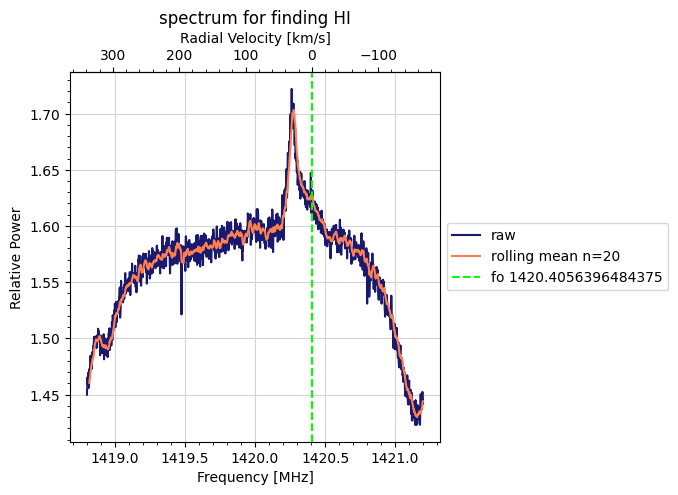

In [118]:
from matplotlib.ticker import AutoMinorLocator

fig, ax1=plt.subplots()
ax1.plot(data.f, data.p, color='midnightblue', label='raw')
ax1.plot(data.f , data.rolp, color='coral', label='rolling mean n=20')

for i in fo_array:
   ax1.axvline(x=i, color='lime', linestyle='--', label=f'fo {i}')


ax1.set_xlabel("Frequency [MHz]")
ax1.set_ylabel("Relative Power")
ax1.yaxis.get_ticklocs(minor=True)
ax1.xaxis.get_ticklocs(minor=True)
ax1.minorticks_on()
ax1.set_box_aspect(1.0)

ax2=ax1.secondary_xaxis('top', functions=(u, inv))
ax2.set_xlabel("Radial Velocity [km/s]")
ax2.xaxis.get_ticklocs(minor = True)
ax2.xaxis.set_minor_locator(AutoMinorLocator())

plt.grid(True, linestyle ="solid", c="lightgrey")
plt.title("spectrum for finding HI")
plt.legend(loc="center left",bbox_to_anchor=(1, 0.5), ncol=1)

plt.show()
